# Libraries and Helper Functions

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# Split Dataset

In [3]:
# load and split data
main_df = pd.read_csv('full_dataset.csv')
train_df, test_df = train_test_split(main_df, test_size = .2, random_state = 42)

Train Size: (33692, 90)
Test Size: (8423, 90)


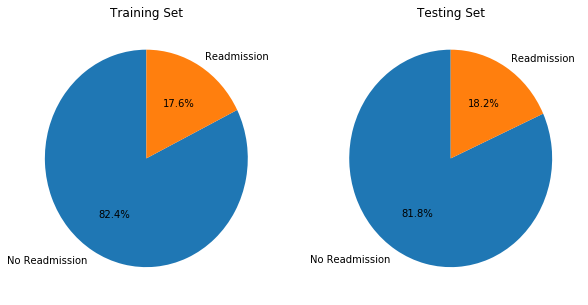

In [23]:
# print total size
print("Train Size: {0}".format(train_df.shape))
print("Test Size: {0}".format(test_df.shape))

# get class counts by dataset
train_no_readmission = train_df[train_df['READMISSION'] == False].shape[0]
train_readmission = train_df[train_df['READMISSION'] == True].shape[0]
test_no_readmission = test_df[test_df['READMISSION'] == False].shape[0]
test_readmission = test_df[test_df['READMISSION'] == True].shape[0]

# plot dataset splits
labels = ['No Readmission', 'Readmission']
train_graph_data = [train_no_readmission, train_readmission]
test_graph_data = [test_no_readmission, test_readmission]

fig = plt.figure(figsize=(10,5))
train_ax = fig.add_subplot(121)
train_ax.pie(train_graph_data, labels=['No Readmission', 'Readmission'], autopct='%1.1f%%', startangle = 90)
train_ax.set_title('Training Set')

test_ax = fig.add_subplot(122)
test_ax.pie(test_graph_data, labels=['No Readmission', 'Readmission'], autopct='%1.1f%%', startangle = 90)
test_ax.set_title('Testing Set')

plt.show()

In [ ]:
# save train and test datasets
train_df.to_csv('train_dataset.csv', index = False)
test_df.to_csv('test_dataset.csv', index = False)